# **Simulazioni MD con il modulo CMS: CrystalDynamics**

---

## Muovere gli atomi con l'algoritmo _Velocity-Verlet_

### Introduzione

Abbiamo visto come costruire un oggetto [CrystalStructure](../../CMS/MolecularDynamics/CrystalStructure.py) nel tutorial [1-CrystalStructure](1-CrystalStructure.ipynb), poi come usare [CrystalPotential](../../CMS/MolecularDynamics/CrystalPotential.py) per calcolarne energia potenziale e forze nel tutorial [2-CrystalPotential](2-CrystalPotential.ipynb). Successivamente si è visto come trovare una configurazione di minimo _locale_ dell'energia con l'algoritmo di [SteepestDescent](../../CMS/MolecularDynamics/SteepestDescent.py) in [3-SteepestDescent](3-SteepestDescent.ipynb).

Il problema della _dinamica_ molecolare è a _molti corpi_, quindi impossibile da risolvere analiticamente:
$$
m_k \ddot{\vec{r}}_k = \vec{\nabla}_k V(\{\vec{r}_k\}_{k=0,...,N-1})
$$

Immaginiamo di poter quindi approssimare in serie di Taylor l’evoluzione delle posizioni $x(t)$ in un intorno $\Delta t$ sufficientemente piccolo
$$
x(t+\Delta t) = x(t) + \frac12\dot{x}(t)\Delta t + \frac16\ddot{x}(t)\Delta t + \dots
$$

L'obiettivo è avere errori di troncamento piccoli, affinché anche grandi passi temporali $\Delta t$ possano fornire una descrizione affidabile della dinamica. Un test usato per stabilire quanto bene un algoritmo conservi l'energia, è vedere se $\frac{\delta E}{E} < 10^{-5}$. Temperature maggiori possono richiedere _time step_ minori, in quanto i processi si velocizzano a causa dell'agitazione termica.

### Velocity Verlet

Senza entrare troppo nei dettagli, le simulazioni di dinamica in `CMS` sfruttano l'algoritmo _Velocity Verlet_:

\begin{cases}
    x(t+\Delta t) = x(t) + v(t)\Delta t + \frac12 a(t)\Delta t^2
    \\
    \\
    v(t+\Delta t) = v(t) + \frac{a(t) + a(t+\Delta t)}{2} \Delta t
\end{cases}

Si può riassumere in questi passaggi:
* al tempo $t$ si calcolano le forze agenti sugli atomi, che determinano un'accelerazione $a(t)$
* si applicano le forze e si spostano gli atomi:  $x(t) \rightarrow x(t+\Delta t)$
* in questa nuova posizione si ricalcolano le forze, da cui si ottiene $a(t+\Delta t)$
* con la nuova accelerazione si aggiorna la velocità: $v(t) \rightarrow v(t+\Delta t)$
* ora che si hanno tutti gli ingredienti, si aggiornano le posizioni $x(t+\Delta t) \rightarrow x(t+2\Delta t)$

e così via.

### Il problema della temperatura in $\mu\text{-canonico: } (N, V, E)$

Nell'_ensemble_ **micro**canonico si conserva l'energia totale, non la temperatura:
$$
E_{\text{tot}}(0) = E_{\text{tot}}(t),\ \forall\ t
$$
per il teorema di equipartizione:
$$
K(0) = \frac12 \sum_{i=0}^{N-1} (v^{2}_{x}(0) + v^{2}_{y}(0) + v^{2}_{z}(0)) = 
N_{\text{dof}} k_B T_{\text{ini}}
$$
nel nostro caso abbiamo $3$ _gradi di libertà_ traslazionali per ciascun atomo: $N_{\text{dof}} = 3N$. Riassumendo: il teorema di equipartizione afferma che per ogni termine quadratico si ha un contributo $\frac12 k_B T$; poiché le velocità cambiano, cambia l'energia cinetica, perciò dovrà cambiare la temperatura: $T=T(t)$.

Supponiamo di partire da un minimo del potenziale - sappiamo come implementarlo con l'algoritmo di _steepest descent_ - in modo che $V(0) = V_{\text{min}}$, quindi supponiamo che il sistema evolva attorno al minimo per piccole oscillazioni e applichiamo di nuovo il teorema di equipartizione
$$
V(t) \approx V_{\text{min}} + \frac12 
\sum_{i=0}^{N-1} \left[k_x dx^{2}_{i}(t) + k_y dy^{2}_{i}(t) + k_z dz^{2}_{i}(t)\right] = 
V_{\text{min}} + \frac32 k_B T(t)
$$

Allora si avrà:
$$
\begin{cases}
E_{\text{tot}}(0) = E_{\text{tot}}(t) \implies K(0) + V(0) = K(t) + V(t)
\\
\\
\frac32 k_b T(0) + V_\text{min} \approx \frac32 k_b T(t) + V_\text{min} + \frac32 k_b T(t)
\end{cases}
$$
da cui:
$$
T(t) \approx \frac12 T(0)
$$

> ⚠️ Se si desidera effettuare una simulazione a temperatura $T$, bisognerà impostarla ad una temperatura iniziale $T_\text{ini} = 2T$ !

### Velocità iniziale

Le velocità iniziali $v(0)$ vengono estratte randomicamente con distribuzione uniforme in un intervallo $[-C,C]$, con la seguente condizione, imposta dall'energia cinetica media di singola particella, data dalla velocità $\alpha$-esima:
$$
\langle K_{i_{a}} \rangle = \frac12 k_B T  = \frac12 m \langle v^{2}_{\alpha} \rangle
$$
dove:
$$
\frac12 m \langle v^{2}_{\alpha} \rangle = \frac12 \frac{m}{2C} \int_{-C}^{C} v^{2}_{\alpha} dv =
\frac12 \frac{m}{2C} \frac{C^3 - (-C^3)}{3} = \frac12 \frac{m}{3} C^2 \equiv 
\frac12 k_B T 
$$
che dà:
$$
C = \sqrt{\frac{3 k_B T}{m}}
$$
vengono estratti casualmente tutti i $v$, ma essendo un numero finito, non si avrà precisamente $\langle v \rangle = 0$: per conservazione del momento lineare, questo porta l'intera struttura cristallina a traslare con velocità di deriva $\langle v \rangle$. Per eliminare questo effetto, sottraggo la velocità media a tutte le velocità individuali:
$$
\begin{cases}
v_{\alpha}^\text{tot} = \sum_{i=0}^{N-1} v_{i_\alpha}
\\
\\
v_{i_\alpha} \rightarrow v_{i_\alpha} - \frac{v_{\alpha}^\text{tot}}{N} = v_{i_\alpha} - \langle v_{\alpha}\rangle
\end{cases}
$$


Ora, avendo agito sulle velocità, abbiamo cambiato l'energia cinetica e quindi la temperatura; per ottenere quella desiderata $T$, va riscalata la velocità:

$$
\begin{cases}
\frac32 N k_B T' = \frac12 m\sum_{i=0}^{N-1}(v^{2}_{i_x}+v^{2}_{i_y}+v^{2}_{i_z})
\\
\\
v_{i_\alpha} \rightarrow v_{i_\alpha} \sqrt{\frac{T}{T'}}
\end{cases}
$$

### Schema algoritmo

<img src="../images/4-CrystalDynamics/MD-simulation-workflow.png" 
     style="display: block; margin-left: auto; margin-right: auto; margin-top: 0px; width: 700px;">

---

## Costruire un oggetto `CrystalDynamics`

L'oggetto [`CrystalDynamics`](../../CMS/MolecularDynamics/CrystalDynamics.py) di `CMS` contiene la logica dell'algoritmo _Velocity Verlet_. Per essere istanzato, richiede un oggetto [`CrystalStructure`](../../CMS/MolecularDynamics/CrystalStructure.py) da manipolare. In questo caso, si costruisce un cristallo usando le coordinate in [fcc100a256.txt](../../../data/pos-fcc100-random/fcc100a256.txt). Gli altri parametri da fornire in fase di costruzione sono quelli visti nell'introduzione teorica:


<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`atomic_mass`** | float | 108. | Massa degli atomi nel cristallo* in u.a., default per Ag |
| **`dt`** | float | 1e-15 | Time step dell'algoritmo Velocity Verlet |
| **`temp_ini`** | float | 20. | Temperatura iniziale in kelvin della simulazione, N.B.: T_fin ~ T_ini / 2 |

</div>

> ⚠️ *Al momento sono implementate soltanto simulazioni di cristalli con una singola specie atomica.

In [ ]:
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure
# istanzio il cristallo
nomefile = "../../../data/pos-fcc100-random/fcc100a256.txt"
cristallo = CrystalStructure.from_file(nomefile)
# imposto i raggi di cutoff, giunzione e Verlet
cristallo.set_R_C(4.5)
cristallo.set_R_P(4.2)
cristallo.set_R_V(5.)

# scelgo i parametri di simulazione
atomic_mass = 108
time_step = 5.E-15
temp_ini  = 50 

from CMS.MolecularDynamics.CrystalDynamics import CrystalDynamics
# istanzio l'algoritmo
dinamica = CrystalDynamics(
    crystal=cristallo.copy(), # fornisco una copia del cristallo, tornerà utile in seguito
    atomic_mass=atomic_mass,
    dt=time_step,
    temp_ini=temp_ini
)

Ora, per lanciare la simulazione, si utilizza il metodo `CrystalDynamics.run_dynamics()`, con la possibilità di intervenire sui seguenti parametri:

<div align="center">

| Attributo | Tipo | Default | Significato |
| :--- | :--- | :--- | :--- |
| **`n_steps`** | int | / | Numero totale di step che effettua l'algoritmo |
| **`t_th`** | float | 0 | Tempo di termalizzazione: steps da effettuare senza salvare i risultati |
</div>

I risultati poi verranno restituiti raccolti in un [`CrystalDynamicsResult`](../../CMS/MolecularDynamics/CrystalDynamics.py).\
Supponiamo di voler eseguire una **simulazione di 20 ps** con un tempo di **termalizzazione di 3ps**

In [ ]:
tempo_totale = 20E-12 # 20 ps
n_steps = int(tempo_totale / time_step) # calcolo il numero di step necessari
tempo_termalizzazione = 3E-12 # 3 ps

# lancio la simulazione
result = dinamica.run_dynamics(
    n_steps=n_steps,
    t_th=tempo_termalizzazione
)

Gli oggetti `CrystalDynamicsResult` possiedono il metodo `.summary()`, che riassume brevemente l'evoluzione delle grandezze fisiche in gioco durante la simulazione:

In [3]:
result.summary()

Simulation Result:
 - Duration: 20.00 ps
 - Mean Temp: 28.56 ± 1.09 K
 - Mean Energy: -451.79 ± 0.00 eV



Già dal breve riassunto di `.summary()` si può osservare il punto molto importante della temperatura: dopo la fase di termalizzazione, che viene scartata, $T$ oscilla attorno ad un valore medio che si attesta proprio attorno a $\frac12 T_\text{ini}$ !

### Esempio di analisi

L'oggetto `CrystalDynamicsResult` restituito da `CrystalDynamics.run_dynamics()` contiene anche molte informazioni sui valori delle grandezze fisiche _durante_ la simulazione. Ad esempio, l'attributo `energies` è un dizionario con chiave `'total'` *, mentre `temperatures` contiene la storia delle temperature.

> ⚠️ *Alla versione attuale, i `CrystalDynamicsResult` raccolgono soltanto l'energia totale, poiché la storia dell'energia cinetica può essere ricavata dall'array delle temperature; avendo totale e cinetica ad ogni istante poi, si può ottenere l'array del potenziale.

#### Plot: energia e temperatura

Andiamo a graficare le evoluzioni di temperatura e energia durante la simulazione.

/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_67076/3784065886.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
/var/folders/88/gfgbzsfs2m759nlsp4wspv400000gp/T/ipykernel_67076/3784065886.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


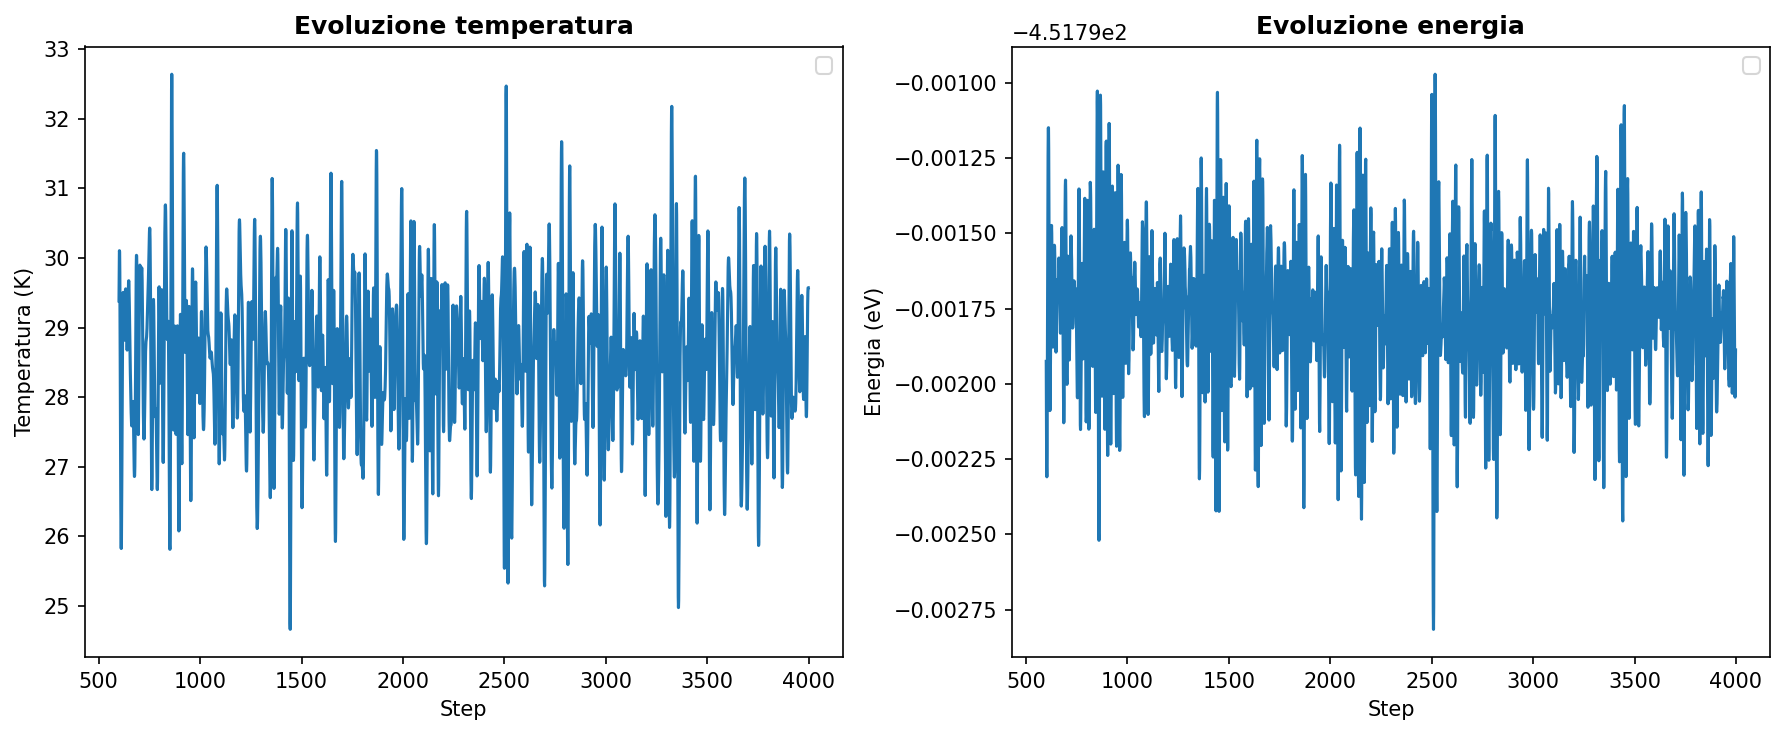

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

x = np.arange(int(tempo_termalizzazione / time_step), n_steps, 1)

# Temperatura #
ax[0].plot(x, result.temperatures)

ax[0].set_title("Evoluzione temperatura", fontweight='bold')
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Temperatura (K)")

# Energia #
ax[1].plot(x, result.energies['total'])

ax[1].set_title("Evoluzione energia", fontweight='bold')
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Energia (eV)")

plt.tight_layout()
plt.show()